# Matrix resolution of an AC circuit via Kirchhoff, including transient

Let's imagine the AC electrical circuit below : (already solved using phasors)

![](./12_4.png)

with :

- $ U_s = 5 \sin \left( \omega t + \frac{\pi}{4}\right) $ [$V$]
- $ R_1 = 20$ [$\Omega$]
- $ R_2 = 30$ [$\Omega$]
- $ R_3 = 10$ [$\Omega$]
- $ C_1 = 2$ [$\mu F$]
- $ C_2 = 5$ [$\mu F$]
- $ L = 10$ [$mH$]
- $ f = 50$ [$Hz$]

You're asked to :
- Find the transfer function linking the current $I_6(s)$ through the inductance L to the input voltage $U_s(s)$ and check the duration of the transient. This is done on the basis of Kirchhoff's equations (previously obtained in exercise exo_circuit_phaseurs_1) and a matrix inversion but this time via dynamic systems and no longer complex impedances. For example : using phasors, the current in a capacitor is written $I_c = i \omega C U_c$; using dynamical system: $I_c = s C U_c$ (with $s$; the Laplacian operator).
- Using the Bode diagram, check the steady state current obtained for the input voltage defined above.
- Represent the signal of the source voltage and that of the current (in transient and established state) in the coil as a function of time, on 2 complete periods, with 1000 points, and the same formatting as the graph below.
- Then observe the index response of this circuit (input step: $U_s$, output = 0)
- Draw the bode diagram of the answer (input: $U_s$; output: $U_L$)



In [1]:
R1=20
R2=30
R3=10
C1=0.000002
C2=0.000005
L=0.010

In [2]:
# First way to find the TF : thanks to matrix inversion
# `control` package do not support Matrices so we use sympy

import sympy as sp

s = sp.symbols('s')

ZR1=R1
ZR2=R2
ZR3=R3
ZC1=1/(s*C1)
ZC2=1/(s*C2)
ZL=s*L

Z = sp.Matrix([[ZR1+ZR3, ZC1, 0, ZR2, 0, 0],
              [0, ZC1, 0, 0, -ZC2, 0],
              [0, 0, 0, ZR2, ZC2, -ZL],
              [1, -1, -1, 0, 0, 0],
              [0, 1, 0, -1, 1, 0],
              [1, 0, 0, -1, 0, -1]])

# This inverted matrix contains the TF linking the circuit's currents to the input voltage
Z1 = Z.inv()

# The TF we're interested in
H = sp.cancel(Z1[5, 0])
H

(6.19810600876641e+28*s + 2.95147905179353e+32)/(1.23962120175328e+27*s**2 + 4.81091085442345e+30*s + 8.85443715538058e+33)

In [3]:
# coefs are quite big so we'll divide all the coefs by the s^2 coef

# Split numerator and denominator
num, den = sp.fraction(H)

# Create polynoms to access individual coef
den_poly = sp.Poly(den, s)
num_poly = sp.Poly(num, s)

leading_coeff = den_poly.LC()  # LC = Leading Coefficient

num_norm = num_poly / leading_coeff
den_norm = den_poly / leading_coeff

# Reconstruct the fraction
H = sp.simplify(num_norm.as_expr() / den_norm.as_expr())

H

(50.0*s + 238095.238095238)/(1.0*s**2 + 3880.95238095238*s + 7142857.14285714)

In [4]:
# Second way to find the TF. Here we will use the `control` package
import control as ct

# Creation of the s variable
s = ct.tf('s')
assert s is not None

ZR1=R1
ZR2=R2
ZR3=R3
ZC1=1/(s*C1)
ZC2=1/(s*C2)
ZL=s*L

In [5]:
Z1=ZR1+ZR3
Z2=((ZC1*ZC2)/(ZC1+ZC2))+ZR2
Zth=(Z1*Z2)/(Z1+Z2)
H=(Z2/(Z1+Z2))/(Zth+ZL)
H = ct.minreal(H)
H  # It's the same as previously found

11 states have been removed from the model


TransferFunction(array([5.00000000e+01, 2.38095238e+05]), array([1.00000000e+00, 3.88095238e+03, 7.14285714e+06]))

In [6]:
from math import pi as π

# Steady-state response for a 100 rad/s frequency sine sollicitation (it's our input signal frequency)
mag, phase, omega = ct.frequency_response(H, 50*2*π)

print(mag)
print(180*phase/π)


[0.03337757]
[-6.04520817]


In [7]:
# Comparason to the previously solved exercise exo 1 : We found a current of 0.1669 A
# and a phase of 38.95 ° when the input voltage was 5 V and 45°.

print(5*mag)
print(45+180*phase/π)

[0.16688784]
[38.95479183]


In [8]:
from math import sin
import numpy as np
# Plotting the time-related response for 2 periods

f=50
w=2*π*f
T=1/f
t=np.linspace(0, 2*T, 1000)
us=5*np.sin(w*t+π/4)

# Check the transient duration : Really fast!
p1=ct.poles(H)
p1

array([-1940.47619048+1837.77291771j, -1940.47619048-1837.77291771j])

In [9]:
Transitoire=5*-1/(p1[0].real) # in seconds
Transitoire

np.float64(0.002576687116564418)

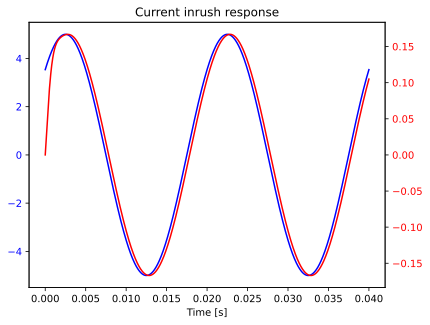

In [10]:
# Ploting the curve : one can see the transient (for about 2 ms) and the amplitude
# and phase matching what we got thanks to Bode command.

from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = ['svg']

_, iL = ct.forced_response(H, t, us)

plt.figure()
plt.xlabel('Time [s]')
plt.title('Current inrush response')
plt.tick_params(axis='y', labelcolor='b')
plt.plot(t, us, 'b')
plt.twinx()
plt.tick_params(axis='y', labelcolor='r')
plt.plot(t, iL, 'r')
plt.show()

In [11]:
# New FT linking Ul to Us :

G = ct.minreal(ZL*H)
G

0 states have been removed from the model


TransferFunction(array([5.00000000e-01, 2.38095238e+03, 0.00000000e+00]), array([1.00000000e+00, 3.88095238e+03, 7.14285714e+06]))

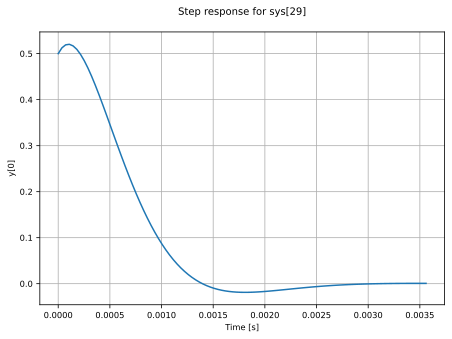

In [12]:
ct.step_response(G).plot()
plt.grid()
plt.show()

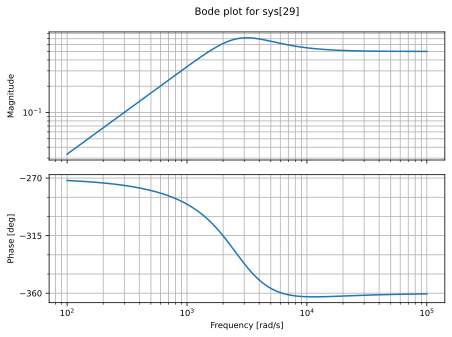

In [13]:
ct.bode(G)
plt.show()